In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    # Python random seed
    random.seed(seed)
    
    # NumPy seed
    np.random.seed(seed)
    
    # PyTorch seed 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
seed_everything(seed)

In [3]:
input_file = '/kaggle/input/house-loan-data-analysis-deep-learning/loan_data (1).csv'
pd.set_option('display.max_columns', None)  # show all column when print df

df = pd.read_csv(input_file, on_bad_lines='skip')
df = df[df.columns.drop(list(df.filter(regex='FLAG_DOCUMENT_')))]  # drop the unknown/without explanation column
df = df[df.columns.drop(list(df.filter(regex='EXT_SOURCE_')))]  # drop the unknown/without explanation column

In [4]:
df = df.drop(['SK_ID_CURR'], axis=1)  # drop the user ID column
df = df.fillna(-1)  # fill the nan values with -1

In [5]:
le = preprocessing.LabelEncoder()
columns = df.columns.values
for column in columns:
    if df[column].dtype != np.int64 and df[column].dtype != np.float64:  # transform all non int/float values to str for label encoding
        df[column] = le.fit_transform(df[column].astype(str))

In [6]:
feature_name = df.drop(['TARGET'], axis=1).columns
df_target_1 = df.loc[df['TARGET'] == 1].reset_index(drop=True)
df_target_0 = df.loc[df['TARGET'] == 0].sample(n=df_target_1.shape[0])  # balance the number of data of TARGET==0 and TARGET==1
df_sampled = pd.concat([df_target_1, df_target_0], ignore_index=True)  # combine the TARGET==0 and TARGET==1 data to single df
df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)

In [7]:
X = df_sampled.drop(['TARGET'], axis=1).values
y = df_sampled['TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = XGBClassifier()  # use XGBoost to find the feature importance
model.fit(X_train, y_train)
importance = model.feature_importances_

In [8]:
top20 = np.argpartition(importance, -20)[-20:]  # sort out top 20 important features
feature_name_selected = ['TARGET']
print('Top 20 features:')
for i in top20:
    feature_name_selected.append(feature_name[i])

processed_data = df_sampled[feature_name_selected]
print(processed_data)

Top 20 features:
       TARGET  AMT_ANNUITY  DAYS_LAST_PHONE_CHANGE  OWN_CAR_AGE  \
0           1      36207.0                     0.0         -1.0   
1           1      21609.0                  -510.0         30.0   
2           1      37125.0                 -2421.0          1.0   
3           0      25987.5                 -3097.0         -1.0   
4           0      43600.5                 -1315.0          6.0   
...       ...          ...                     ...          ...   
49645       1      18387.0                  -299.0         14.0   
49646       1      74128.5                  -646.0         -1.0   
49647       0      22099.5                 -1198.0         -1.0   
49648       1      27679.5                    -9.0         -1.0   
49649       1      51948.0                 -2373.0          2.0   

       DEF_60_CNT_SOCIAL_CIRCLE  FLOORSMAX_MODE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                           0.0         -1.0000      -12359           -948   
1                     

In [9]:
processed_data.to_csv('train_data.csv', index=False, header=True)  # save the training dataset with 20 features and 1 ground truth
df_sampled.to_csv('balanced_data.csv', index=False, header=True)  # save the balanced dataset with all features

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

# XGBoost

In [11]:
# use top 20 features and XGBoost model to predict 
df = pd.read_csv('train_data.csv')
df = df.drop(['TARGET'], axis=1)  # drop the target column
X = df.values
y = pd.read_csv('train_data.csv', on_bad_lines='skip')
y = y['TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

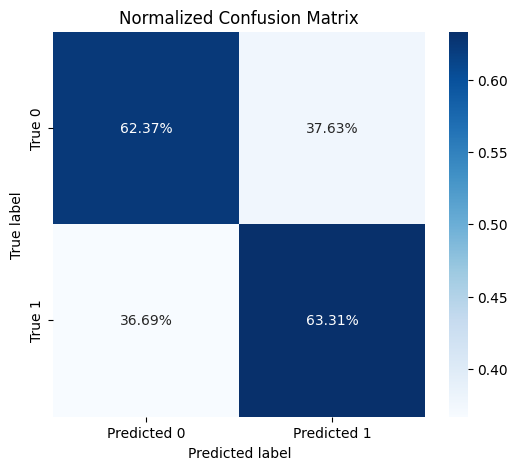

Accuracy: 0.628373
F1-score: 0.628553


In [12]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Generate confusion matrix and normalize by total number of samples
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true class)

# Plot confusion matrix with normalized values
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print accuracy and F1-score
print(f'Accuracy: {accuracy:.6f}')
print(f'F1-score: {f1:.6f}')

# Random Forest

In [13]:
# use top 20 features and random forest model to predict
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('train_data.csv')
df = df.drop(['TARGET'], axis=1)  # drop the target column
X = df.values
y = pd.read_csv('train_data.csv', on_bad_lines='skip')
y = y['TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

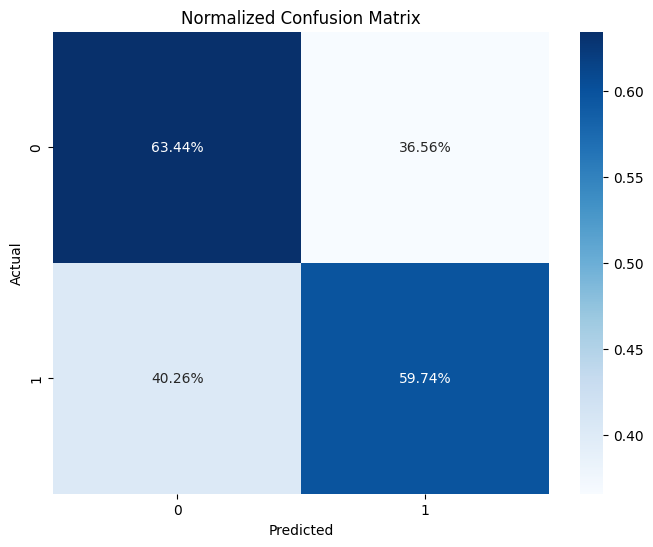

Accuracy: 0.616048
F1-score: 0.607155


In [14]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred)  

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to get proportions
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the results
print(f'Accuracy: {accuracy:.6f}')
print(f'F1-score: {f1:.6f}')

# TabNet

In [15]:
!pip install /kaggle/input/tabnet-3-1-1-tar-gz/tabnet-3.1.1

Processing /kaggle/input/tabnet-3-1-1-tar-gz/tabnet-3.1.1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytorch_tabnet: filename=pytorch_tabnet-3.1.1-py3-none-any.whl size=39259 sha256=946d7c7d980d06370eedeadf632bcd243a24c131d20d2b3453e297e1949c6965
  Stored in directory: /root/.cache/pip/wheels/21/30/f5/f517132a816671044cd54b727c544cea2477ff85653181974b
Successfully built pytorch_tabnet
  Attempting uninstall: pytorch_tabnet
    Found existing installation: pytorch_tabnet 3.1.1
    Uninstalling pytorch_tabnet-3.1.1:
      Successfully uninstalled pytorch_tabnet-3.1.1


In [16]:
import torch

if not hasattr(torch, "compile"):
    torch.compile = lambda model, **kwargs: model

In [17]:
# use top 20 features and TabNet model to predict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('train_data.csv')

y = df['TARGET'].values
X = df.drop(['TARGET'], axis=1).values

if df['TARGET'].dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = TabNetClassifier(verbose=0, seed=0)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10
)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


Early stopping occurred at epoch 45 with best_epoch = 35 and best_test_accuracy = 0.62523
Best weights from best epoch are automatically used!


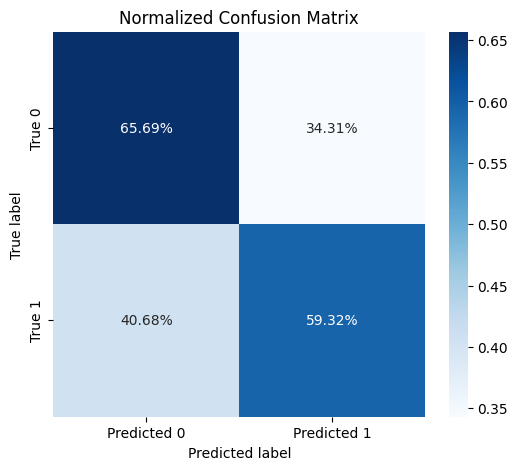

Accuracy: 0.625232
F1-score: 0.611232


In [18]:
# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Generate confusion matrix and normalize by total number of samples
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true class)

# Plot confusion matrix with normalized values
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print accuracy and F1-score
print(f'Accuracy: {accuracy:.6f}')
print(f'F1-score: {f1:.6f}')

# FT - transformer

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
data = pd.read_csv('train_data.csv')
data.columns

Index(['TARGET', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_MODE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE',
       'AMT_GOODS_PRICE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_EMP_PHONE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'AMT_CREDIT', 'APARTMENTS_MEDI',
       'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE'],
      dtype='object')

In [21]:
# Define feature columns
categorical_cols = ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE']
numerical_cols = ['AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
                  'FLOORSMAX_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
                  'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AMT_CREDIT']
target_col = ['TARGET']

# Encode categorical variables
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

# Extract X and y
X = data[numerical_cols + categorical_cols]
y = data["TARGET"].values

# Normalize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_num = torch.tensor(X_train[numerical_cols].values, dtype=torch.float32)
X_train_cat = torch.tensor(X_train[categorical_cols].values, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test_num = torch.tensor(X_test[numerical_cols].values, dtype=torch.float32)
X_test_cat = torch.tensor(X_test[categorical_cols].values, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

<ipython-input-21-679e66a8fedf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [22]:
# Dataset and Dataloader
class TabularDataset(Dataset):
    def __init__(self, num_x, cat_x, y):
        self.num_x = num_x
        self.cat_x = cat_x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.num_x[idx], self.cat_x[idx], self.y[idx]

train_dataset = TabularDataset(X_train_num, X_train_cat, y_train)
test_dataset = TabularDataset(X_test_num, X_test_cat, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# FT-Transformer-like model definition
class SimpleFTTransformer(nn.Module):
    def __init__(self, num_numerical, cat_cardinalities, d_token=32, num_classes=2):
        super().__init__()
        self.cat_embeddings = nn.ModuleList([nn.Embedding(card, d_token) for card in cat_cardinalities])
        self.num_linear = nn.Linear(num_numerical, d_token)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_token, nhead=4, dim_feedforward=128)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        self.output = nn.Linear(d_token, num_classes)

    def forward(self, x_num, x_cat):
        embedded_cat = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x_cat_embed = torch.stack(embedded_cat, dim=1).mean(dim=1)
        x_num_embed = self.num_linear(x_num)
        x_combined = x_num_embed + x_cat_embed
        x_transformed = self.transformer(x_combined.unsqueeze(1)).squeeze(1)
        out = self.output(x_transformed)
        return out

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cat_cardinalities = [int(data[col].nunique()) for col in categorical_cols]
model = SimpleFTTransformer(num_numerical=len(numerical_cols), cat_cardinalities=cat_cardinalities).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train loop
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    for epoch in range(15):
        total_loss = 0
        for x_num, x_cat, y in loader:
            x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_num, x_cat)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

train_model(model, train_loader, optimizer, criterion, device)

Epoch 1, Loss: 0.6602
Epoch 2, Loss: 0.6514
Epoch 3, Loss: 0.6502
Epoch 4, Loss: 0.6478
Epoch 5, Loss: 0.6464
Epoch 6, Loss: 0.6442
Epoch 7, Loss: 0.6438
Epoch 8, Loss: 0.6436
Epoch 9, Loss: 0.6423
Epoch 10, Loss: 0.6423
Epoch 11, Loss: 0.6412
Epoch 12, Loss: 0.6406
Epoch 13, Loss: 0.6398
Epoch 14, Loss: 0.6391
Epoch 15, Loss: 0.6383


In [23]:
# Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x_num, x_cat, y in test_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        out = model(x_num, x_cat)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

accuracy, f1, cm, cm_percent

(0.6265861027190333,
 0.6230941248221182,
 array([[3157, 1851],
        [1857, 3065]]),
 array([[0.63039137, 0.36960863],
        [0.37728566, 0.62271434]]))

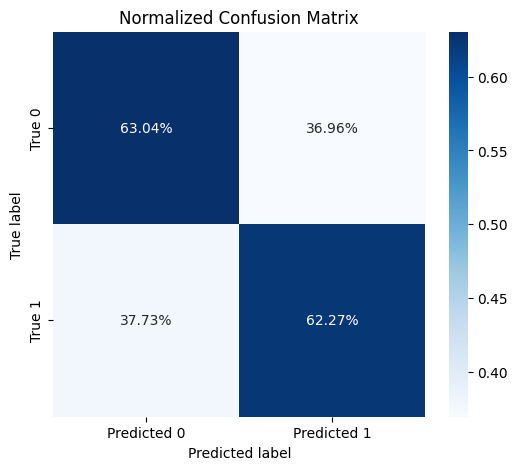

Accuracy: 0.626586
F1-score: 0.623094


In [24]:
# Plot confusion matrix with normalized values
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print accuracy and F1-score
print(f'Accuracy: {accuracy:.6f}')
print(f'F1-score: {f1:.6f}')

# NODE

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NODEBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, tree_depth=3, num_trees=2):
        super(NODEBlock, self).__init__()
        self.tree_depth = tree_depth
        self.num_trees = num_trees
        self.decision_fn = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2 ** tree_depth),
                nn.Sigmoid()
            ) for _ in range(num_trees)
        ])
        self.leaf_scores = nn.Parameter(torch.randn(num_trees, 2 ** tree_depth, hidden_dim))

    def forward(self, x):
        outputs = []
        for i in range(self.num_trees):
            decisions = self.decision_fn[i](x)  # (batch, 2^depth)
            leaf_prob = decisions / decisions.sum(dim=1, keepdim=True)  # Normalize
            tree_output = torch.matmul(leaf_prob, self.leaf_scores[i])  # (batch, hidden_dim)
            outputs.append(tree_output)
        return torch.sum(torch.stack(outputs), dim=0)  # Sum all tree outputs
        

class NODEModel(nn.Module):
    def __init__(self, num_numerical, cat_cardinalities, embed_dim=8, hidden_dim=64, output_dim=2):
        super(NODEModel, self).__init__()
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(cardinality, embed_dim)
            for name, cardinality in cat_cardinalities.items()
        })
        self.node = NODEBlock(input_dim=num_numerical + embed_dim * len(cat_cardinalities),
                              hidden_dim=hidden_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, numerical, categorical):
        cat_embeds = [self.embeddings[name](categorical[name]) for name in categorical]
        cat_concat = torch.cat(cat_embeds, dim=1)
        x = torch.cat([numerical, cat_concat], dim=1)
        x = self.node(x)
        return self.classifier(x)


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader


# Define categorical and numerical columns
categorical_cols = ['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'CODE_GENDER']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['TARGET']]

# Encode categorical features
encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_cols}
for col in categorical_cols:
    data[col] = encoders[col].transform(data[col])

# Prepare categorical tensors and cardinalities
cat_features = {col: data[col].values for col in categorical_cols}
cat_cardinalities = {col: data[col].nunique() for col in categorical_cols}

# Normalize numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(data[numerical_cols])
y = data['TARGET'].values

# Train-test split
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)
X_num_train, X_num_test = X_num[train_idx], X_num[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
cat_train = {col: values[train_idx] for col, values in cat_features.items()}
cat_test = {col: values[test_idx] for col, values in cat_features.items()}

# Dataset class
class TabularDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.FloatTensor(X_num)
        self.X_cat = {k: torch.LongTensor(v) for k, v in X_cat.items()}
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_num[idx], {k: v[idx] for k, v in self.X_cat.items()}, self.y[idx]

# Create dataloaders
train_dataset = TabularDataset(X_num_train, cat_train, y_train)
test_dataset = TabularDataset(X_num_test, cat_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NODEModel(
    num_numerical=len(numerical_cols),
    cat_cardinalities=cat_cardinalities,
    embed_dim=8,
    hidden_dim=64,
    output_dim=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_num, X_cat, y in loader:
        X_num = X_num.to(device)
        X_cat = {k: v.to(device) for k, v in X_cat.items()}
        y = y.to(device)

        optimizer.zero_grad()
        out = model(X_num, X_cat)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for X_num, X_cat, y in loader:
            X_num = X_num.to(device)
            X_cat = {k: v.to(device) for k, v in X_cat.items()}
            y = y.to(device)

            out = model(X_num, X_cat)
            loss = criterion(out, y)

            preds = out.argmax(1)
            all_targets.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            total_loss += loss.item()
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(loader)
    acc = correct / total
    return avg_loss, acc, all_targets, all_preds

# Training loop
for epoch in range(15):
    train_loss, train_acc = train_epoch(model, train_loader)
    test_loss, test_acc, all_targets, all_preds = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={test_loss:.4f}, Val Acc={test_acc:.4f}")

test_loss, test_acc, all_targets, all_preds = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch 1: Train Loss=0.6609, Train Acc=0.6096, Val Loss=0.6581, Val Acc=0.6134
Epoch 2: Train Loss=0.6528, Train Acc=0.6174, Val Loss=0.6544, Val Acc=0.6185
Epoch 3: Train Loss=0.6520, Train Acc=0.6190, Val Loss=0.6549, Val Acc=0.6155
Epoch 4: Train Loss=0.6506, Train Acc=0.6206, Val Loss=0.6519, Val Acc=0.6230
Epoch 5: Train Loss=0.6499, Train Acc=0.6201, Val Loss=0.6543, Val Acc=0.6160
Epoch 6: Train Loss=0.6490, Train Acc=0.6210, Val Loss=0.6544, Val Acc=0.6177
Epoch 7: Train Loss=0.6486, Train Acc=0.6234, Val Loss=0.6552, Val Acc=0.6144
Epoch 8: Train Loss=0.6489, Train Acc=0.6226, Val Loss=0.6510, Val Acc=0.6235
Epoch 9: Train Loss=0.6479, Train Acc=0.6237, Val Loss=0.6503, Val Acc=0.6219
Epoch 10: Train Loss=0.6480, Train Acc=0.6232, Val Loss=0.6504, Val Acc=0.6249
Epoch 11: Train Loss=0.6471, Train Acc=0.6250, Val Loss=0.6498, Val Acc=0.6243
Epoch 12: Train Loss=0.6466, Train Acc=0.6238, Val Loss=0.6491, Val Acc=0.6244
Epoch 13: Train Loss=0.6461, Train Acc=0.6256, Val Loss=0.650

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


F1 Score (Weighted): 0.6223

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      5008
           1       0.62      0.62      0.62      4922

    accuracy                           0.62      9930
   macro avg       0.62      0.62      0.62      9930
weighted avg       0.62      0.62      0.62      9930



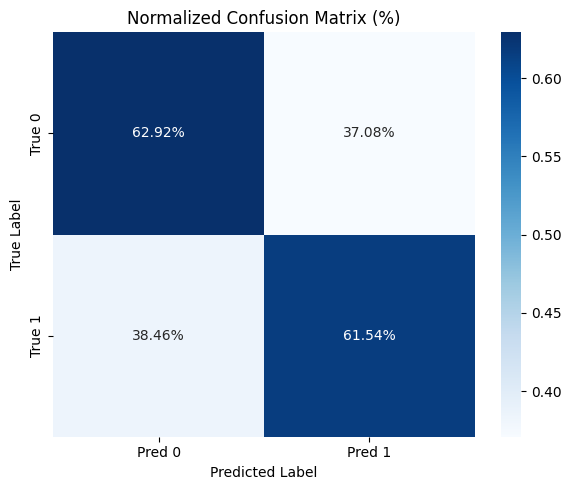

In [30]:
# F1-score
f1 = f1_score(all_targets, all_preds, average='weighted') 
print(f"\nF1 Score (Weighted): {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# Confusion Matrix with Proportions
cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues", xticklabels=[f'Pred {i}' for i in range(cm.shape[1])],
            yticklabels=[f'True {i}' for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.tight_layout()
plt.show()
